In [3]:
import sys

import torch

# taken from system.py 
def collate_fn(batch):
    max_frames = 18
    vectors_padded = []
    for b in batch:
        ones = torch.ones(b.shape[0], max_frames - b.shape[1])
        last_val = b[:, -1].unsqueeze(1)
        last_val = last_val.expand_as(ones)

        vectors_padded.append(torch.cat([b, ones * last_val], dim=1))
    return torch.stack(vectors_padded)


In [31]:
import torch

def compute_cinematic(batch: torch.Tensor):
    
    # batch is B, J, T --> need it as T, B, J (2, 0, 1)
    batch = batch.permute(2, 0, 1)
    
    vel = torch.stack([batch[idx+1, ...] - batch[idx, ...] for idx in range(batch.shape[0]-1)])
    # print("velocity shape: {}".format(vel.shape))
    acc = torch.stack([vel[idx+1, ...] - vel[idx, ...] for idx in range(vel.shape[0]-1)])
    # print("acceleration shape: {}".format(acc.shape))
    
    vel, acc = vel.permute(1, 2, 0), acc.permute(1, 2, 0)
    
    return vel, acc

In [ ]:
from dataset import GestureDataset
from pathlib import Path
import torch.nn.functional as F

train_path = Path(r"C:\Users\faval\PycharmProjects\TAG2G\VQVAE\vqvae_data\trn")
trn_dataset = GestureDataset(train_path)
print(f"Dataset max frame: {trn_dataset.max_frames_len}")

test_sample = trn_dataset[52]
print(f"Test sample shape: {test_sample.shape}")

batch_size = 128
batches = len(trn_dataset) // batch_size            # max number of batches I can have given dataset's length and batch_size

gamma = 0.1

print(f"Dataset's length: {len(trn_dataset)}")
print_cinematic_loss = False            # set to True in order to print losses 
print_cinematic_graph = False           # set to True in order to print graph with cinematic parameters

for idx_batch in range(batches):
    
    # building a batch
    batch = [trn_dataset[item] for item in range(batch_size*idx_batch, batch_size*idx_batch+batch_size, 1)]
    batch = collate_fn(batch=batch)
    print(batch.shape, type(batch))
    
    # compute velocity from batch
    vel, acc = compute_cinematic(batch)
    
    print(f"Batch: '{batch.shape}', Vel: {vel.shape}, Acc: {acc.shape}")
    
    if print_cinematic_loss:
        zero_batch = torch.zeros_like(batch)
        zero_vel = torch.zeros_like(vel)
        zero_acc = torch.zeros_like(acc)
        
        mse_pos_loss = F.mse_loss(zero_batch, batch)
        mse_vel_loss = gamma*F.mse_loss(zero_vel, vel)
        mse_acc_loss = gamma*F.mse_loss(zero_acc, acc)
    
        print(f"Batch #{idx_batch}: {mse_pos_loss}, {mse_vel_loss}, {mse_acc_loss}")
        
    if print_cinematic_graph:
        
        pass
        # here i use to print the velocity




===     FROM HERE - TEST WITH ACTUAL PL.lightning DATALOADER USED DURING TRAINING      ====

4it [00:00, 539.77it/s]
4it [00:00, 1326.47it/s]


Train size: 608
Val size: 233
Batch 1:
Shape: torch.Size([128, 74, 18])
torch.Size([128, 74, 18])
torch.Size([18, 128, 74])
Batch: torch.Size([128, 74, 18]), speed: torch.Size([128, 74, 17]), acc: torch.Size([128, 74, 16])
Padding vel
Padding acc
torch.Size([18]) torch.Size([18]) torch.Size([18])


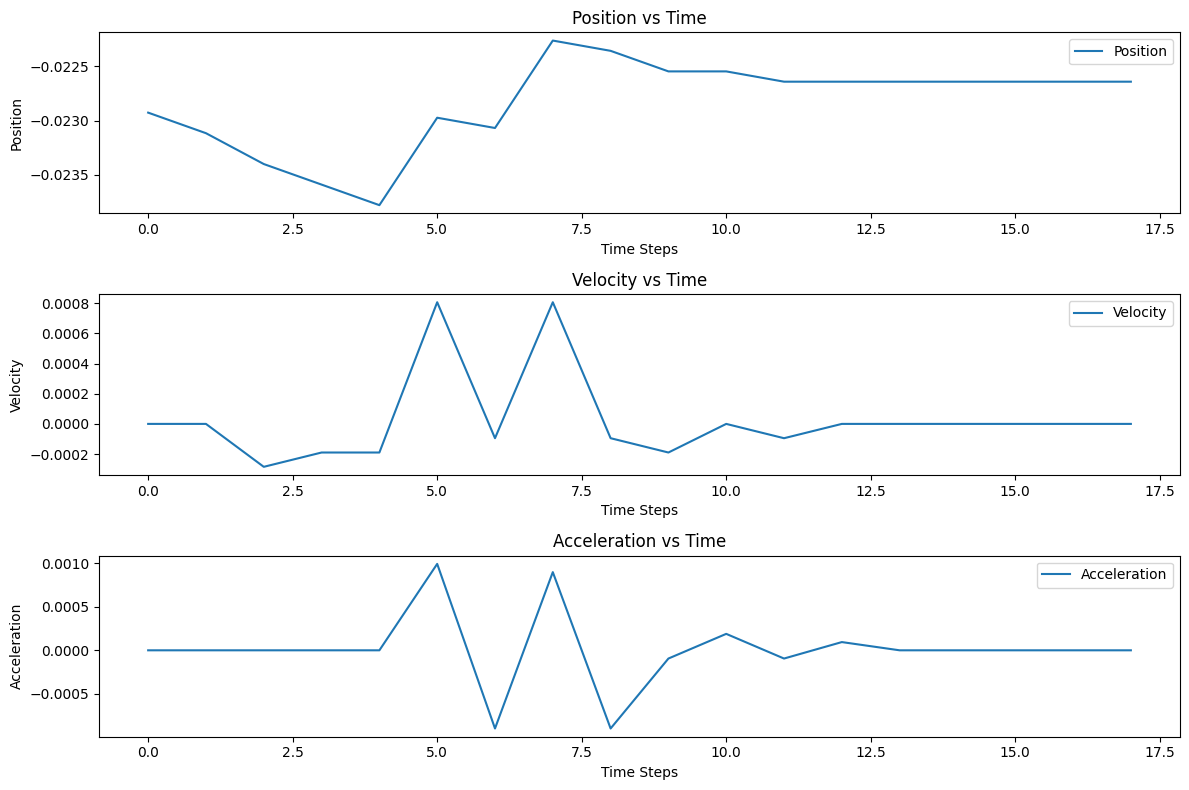

In [33]:
sys.path.append(r"C:\Users\faval\PycharmProjects\TAG2G")

def pad_cinematic(pos, cin):
    
    return torch.concatenate([torch.zeros(len(pos)-len(cin)), cin], dim=0)

import matplotlib.pyplot as plt
from system import VQVAEDataModule 

# Parameters to be used in the VQVAEDataModule
trn_folder = r"C:\Users\faval\PycharmProjects\TAG2G\VQVAE\vqvae_data\trn"
val_folder = r"C:\Users\faval\PycharmProjects\TAG2G\VQVAE\vqvae_data\val"
base_kwargs = {
    'trn_data_path': trn_folder,
    'val_data_path': val_folder,
    'batch_size': 128,
    'max_frames': 18,
    'num_workers': 8
}

# Instantiate your data module
data_module = VQVAEDataModule(**base_kwargs)

# Setup the data module (load datasets)
data_module.setup()

# Create the dataloader
train_dataloader = data_module.train_dataloader()

# Iterate through batches and print their content
for i, batch in enumerate(train_dataloader):
    
    if i == 0:
        print(f"Batch {i + 1}:")
        print(f"Shape: {batch.shape}")
        
        vel, acc = compute_cinematic(batch)
        
        print(f"Batch: {batch.shape}, speed: {vel.shape}, acc: {acc.shape}")
        
        # Add any additional code to inspect or process the batch as needed
        pos = batch[0, 0, ...]      
        vel = vel[0, 0, 1:]
        acc = acc[0, 0, 2:]
        
        if len(vel) != len(pos):
            print(f"Padding vel")
            vel = pad_cinematic(pos, vel)

        if len(acc) != len(pos):
            print(f"Padding acc")
            acc = pad_cinematic(pos, acc)
            
        
        # plot position, velocity and acceleration
        print(pos.shape, vel.shape, acc.shape)
        
        # Extract values for plotting
        time_steps = range(pos.shape[0])
        
        plt.figure(figsize=(12, 8))
        
        plt.subplot(3, 1, 1)
        plt.plot(time_steps, pos, label='Position')
        plt.title('Position vs Time')
        plt.xlabel('Time Steps')
        plt.ylabel('Position')
        plt.legend()
        
        plt.subplot(3, 1, 2)
        plt.plot(time_steps, vel, label='Velocity')
        plt.title('Velocity vs Time')
        plt.xlabel('Time Steps')
        plt.ylabel('Velocity')
        plt.legend()
        
        plt.subplot(3, 1, 3)
        plt.plot(time_steps, acc, label='Acceleration')
        plt.title('Acceleration vs Time')
        plt.xlabel('Time Steps')
        plt.ylabel('Acceleration')
        plt.legend()
        
        plt.tight_layout()
        plt.show()